In [33]:
### Import Libraries ###
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import deque

In [29]:
### Calculate camera calibration matrix and distortion coefficients ###
def Calibration_Matrix (List_Files, nx, ny):
    Objects_Points = []
    Image_Points = []
    for Files in List_Files:

        Obj_Pts = np.zeros((nx*ny,3), np.float32)
        Obj_Pts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape (-1,2)
        #Find chessboard corners on distorted chessboard image    
        img = cv2.imread(Files)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            Image_Points.append(corners)
            Objects_Points.append(Obj_Pts)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(Objects_Points, Image_Points, gray.shape[::-1], None, None)
    return mtx, dist

############################################################
### Calculate binary threshold images based on gradients ###
############################################################
def Absolute_Sobel_Threshold(Img, orient='x', sobel_kernel=3, Abs_thresh=(0, 255)):
    gray = cv2.cvtColor(Img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        Sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    if orient == 'y':
        Sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    Abs_Sobel = np.absolute(Sobel)
    Scaled_Sobel = np.uint8(255*Abs_Sobel/np.max(Abs_Sobel))
    grad_binary = np.zeros_like(Scaled_Sobel)
    grad_binary[(Scaled_Sobel >= Abs_thresh[0]) & (Scaled_Sobel <= Abs_thresh[1])] = 1
    return grad_binary

def Magnitude_Threshold(Img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(Img, cv2.COLOR_RGB2GRAY)
    Sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    Sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    Mag_Sobelxy = np.sqrt(np.square(Sobelx) + np.square(Sobely))
    Scaled_Mag_Sobelxy = np.uint8(255*Mag_Sobelxy/np.max(Mag_Sobelxy))
    mag_binary = np.zeros_like(Scaled_Mag_Sobelxy)
    mag_binary[(Scaled_Mag_Sobelxy >= mag_thresh[0]) & (Scaled_Mag_Sobelxy <= mag_thresh[1])] = 1
    return mag_binary

def Direction_Threshold(Img, sobel_kernel=3, dir_thresh=(0.7,1.3)):
    gray = cv2.cvtColor(Img, cv2.COLOR_RGB2GRAY)
    Sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel)
    Sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize = sobel_kernel)
    Abs_Sobelx = np.absolute(Sobelx)
    Abs_Sobely = np.absolute(Sobely)
    Grad_Dir = np.arctan2(Abs_Sobely, Abs_Sobelx)
    dir_binary = np.zeros_like(Grad_Dir)
    dir_binary[(Grad_Dir >= dir_thresh[0]) & (Grad_Dir <= dir_thresh[1])] = 1
    return dir_binary

#########################################################
### Calculate binary threshold images based on colors ###
#########################################################
def S_Color_Threshold(Img, S_Color_thresh = (0, 255)):
    hls = cv2.cvtColor(Img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    S_binary = np.zeros_like(S)
    S_binary[(S >= S_Color_thresh[0]) & (S <= S_Color_thresh[1])] = 1
    
    return S_binary

#############################
### Determine Lane pixels ###
#############################
def Identify_Lane_Pixels(Binary_Warped_Img):
    #Identify starting points for pixel search based on the histogram
    histogram = np.sum(Binary_Warped_Img[Binary_Warped_Img.shape[0]//2:,:], axis=0)
    Left_x_Start = np.argmax(histogram[:histogram.shape[0]//2])
    Right_x_Start = np.argmax(histogram[histogram.shape[0]//2:]) + histogram.shape[0]//2
    
    #Search parameters
    Window_Number = 10
    Margin = 110
    Min_Pixel = 50

    Final_Out_Img = np.dstack((Binary_Warped_Img, Binary_Warped_Img, Binary_Warped_Img))*255

    Window_Height = np.int(Binary_Warped_Img.shape[0]//Window_Number)
    
    #Identifying indexes of all active pixels
    Non_Zero = Binary_Warped_Img.nonzero()
    Non_Zero_x = np.array(Non_Zero[1])
    Non_Zero_y = np.array(Non_Zero[0])

    #Initializing the search
    Left_Lane_Ind = []
    Right_Lane_Ind = []
    Left_x_Current = Left_x_Start
    Right_x_Current = Right_x_Start
    
    # Search over the windows
    for n in range(Window_Number):
        #Identify window boundaries
        Window_y_Low = Binary_Warped_Img.shape[0] - (n+1)*Window_Height
        Window_y_High = Binary_Warped_Img.shape[0] - n*Window_Height
        Window_Left_x_Low = Left_x_Current - Margin
        Window_Left_x_High = Left_x_Current + Margin
        Window_Right_x_Low = Right_x_Current - Margin
        Window_Right_x_High = Right_x_Current + Margin
        
        #Draw window boundaries on image output
        cv2.rectangle(Final_Out_Img,(Window_Left_x_Low, Window_y_Low), (Window_Left_x_High, Window_y_High), (255,0,0),2)
        cv2.rectangle(Final_Out_Img,(Window_Right_x_Low, Window_y_Low), (Window_Right_x_High, Window_y_High), (255,0,0),2)

        #Identify active pixels within the window boundaries      
        Left_Ok = ((Non_Zero_y >= Window_y_Low) & (Non_Zero_y < Window_y_High) &
                   (Non_Zero_x >= Window_Left_x_Low) & (Non_Zero_x < Window_Left_x_High)).nonzero()[0]

        Right_Ok = ((Non_Zero_y >= Window_y_Low) & (Non_Zero_y < Window_y_High) &
                   (Non_Zero_x >= Window_Right_x_Low) & (Non_Zero_x < Window_Right_x_High)).nonzero()[0]
        
        #Add found pixels to the whole list of active pixels
        Left_Lane_Ind.append(Left_Ok)
        Right_Lane_Ind.append(Right_Ok)
        
        #Recenter the window if needed
        if len(Left_Ok) > Min_Pixel:
            Left_x_Current = np.int(np.mean(Non_Zero_x[Left_Ok]))
        if len(Right_Ok) > Min_Pixel:
            Right_x_Current = np.int(np.mean(Non_Zero_x[Right_Ok]))
    
    try:
        Left_Lane_Ind = np.concatenate(Left_Lane_Ind)
        Right_Lane_Ind = np.concatenate(Right_Lane_Ind)
    except ValueError:
        pass

    #Extract all active pixels for left and right lane
    Left_x_Active = Non_Zero_x[Left_Lane_Ind]
    Left_y_Active = Non_Zero_y[Left_Lane_Ind]
    Right_x_Active = Non_Zero_x[Right_Lane_Ind]
    Right_y_Active = Non_Zero_y[Right_Lane_Ind]
    
    return Left_x_Active, Left_y_Active, Right_x_Active, Right_y_Active, Final_Out_Img

################################
### Fit over the lane pixels ###
################################
def Fit_Lanes (Binary_Warped_Img):
    Left_x_Active, Left_y_Active, Right_x_Active, Right_y_Active, Final_Out_Img= Identify_Lane_Pixels(Binary_Warped_Img)
    
    #Fit a second order polynomial over the founded active pixel for each lane
    Left_Lane_Fit = np.polyfit(Left_y_Active, Left_x_Active, 2)
    Right_Lane_Fit = np.polyfit(Right_y_Active, Right_x_Active, 2)

    Plot_y= np.linspace(0, Binary_Warped_Img.shape[0]-1, Binary_Warped_Img.shape[0])
    
    try:
        Left_Lane_Fit_x = Left_Lane_Fit[0]*Plot_y**2 + Left_Lane_Fit[1]*Plot_y + Left_Lane_Fit[2]
        Right_Lane_Fit_x = Right_Lane_Fit[0]*Plot_y**2 + Right_Lane_Fit[1]*Plot_y + Right_Lane_Fit[2]
    except TypeError:
        # Avoidserror if fit was still impossible
        print('Fit not possible')
        Left_Lane_Fit_x = 1*Plot_y*2 + 1*Plot_y
        Right_Lane_Fit_x = 1*Plot_y*2 + 1*Plot_y

    #Plot polynomial fits of lane with activate pixels
#     plt.plot(Left_Lane_Fit_x, Plot_y, color = 'yellow')
#     plt.plot(Right_Lane_Fit_x, Plot_y, color = 'yellow')
    Final_Out_Img[Left_y_Active, Left_x_Active] = [255,0,0]
    Final_Out_Img[Right_y_Active, Right_x_Active] = [0,255,0]
    
    return Final_Out_Img, Left_Lane_Fit, Right_Lane_Fit

#######################################################
### Lane curvature and vehicle position Measurement ###
#######################################################
def Lane_Curvatures (Binary_Warped_Img, Left_Lane_Fit, Right_Lane_Fit, Scale_Meter_Pixel_x, Scale_Meter_Pixel_y):
    #Curvature at the bottom of the image
    Y_Eval = Binary_Warped_Img.shape[0]
    
    #Calculation of curvature in Pixel
    Left_Curve_Radius_Pixel = ((1 + (2*Left_Lane_Fit[0]*Y_Eval + Left_Lane_Fit[1])**2)**1.5) / np.absolute(2*Left_Lane_Fit[0])
    
    Right_Curve_Radius_Pixel = ((1 + (2*Right_Lane_Fit[0]*Y_Eval + Right_Lane_Fit[1])**2)**1.5) / np.absolute(2*Right_Lane_Fit[0])
    
    #Lane Fit parameter conversion from pixel to meter
    Left_Lane_Fit_Meter =[Left_Lane_Fit[0]*Scale_Meter_Pixel_x/(Scale_Meter_Pixel_y**2),
                          Left_Lane_Fit[1]*Scale_Meter_Pixel_x/Scale_Meter_Pixel_y,
                          Left_Lane_Fit[2]]
    Right_Lane_Fit_Meter =[Right_Lane_Fit[0]*Scale_Meter_Pixel_x/(Scale_Meter_Pixel_y**2),
                          Right_Lane_Fit[1]*Scale_Meter_Pixel_x/Scale_Meter_Pixel_y,
                          Right_Lane_Fit[2]]
    Y_Eval_Meter = Y_Eval*Scale_Meter_Pixel_y
    
    #Calculation of curvature in meter
    Left_Curve_Radius_Meter = ((1 + (2*Left_Lane_Fit_Meter[0]*Y_Eval_Meter + Left_Lane_Fit_Meter[1])**2)**1.5) / np.absolute(2*Left_Lane_Fit_Meter[0])
    
    Right_Curve_Radius_Meter = ((1 + (2*Right_Lane_Fit_Meter[0]*Y_Eval_Meter + Right_Lane_Fit_Meter[1])**2)**1.5) / np.absolute(2*Right_Lane_Fit_Meter[0])
    
    Left_Lane_Base = Left_Lane_Fit[0]*Y_Eval**2 + Left_Lane_Fit[1]*Y_Eval + Left_Lane_Fit[2]
    Right_Lane_Base = Right_Lane_Fit[0]*Y_Eval**2 + Right_Lane_Fit[1]*Y_Eval + Right_Lane_Fit[2]
    
    Vehicle_Relative_Pos_Meter = ((Binary_Warped_Img.shape[1]/2) - ((Left_Lane_Base + Right_Lane_Base)/2))*Scale_Meter_Pixel_x
    
#     print ('Vehicle relative position to lane center in meters: ',Vehicle_Relative_Pos,
#            '\nLeft lane curvature in pixel: ', Left_Curve_Radius_Pixel,
#            '\nRight lane curvature in pixel: ', Right_Curve_Radius_Pixel, 
#            '\nLeft lane curvature in meters: ', Left_Curve_Radius_Meter,
#            '\nRight lane curvature in meters: ', Right_Curve_Radius_Meter)
    Result = np.array([Vehicle_Relative_Pos_Meter, Left_Curve_Radius_Meter, Right_Curve_Radius_Meter, Left_Curve_Radius_Pixel, Right_Curve_Radius_Pixel])
    return Result

#############################################
### Draw the Lane on the undistorde image ###
#############################################
def Draw_Lane (Undistorted_Img, Binary_Warped_Img, Left_Lane_Fit, Right_Lane_Fit):
    
    Unwarped = np.dstack((Binary_Warped_Img, Binary_Warped_Img, Binary_Warped_Img))*0
    Plot_y= np.linspace(0, Binary_Warped_Img.shape[0]-1, Binary_Warped_Img.shape[0])
    Left_Lane_Fit_x = Left_Lane_Fit[0]*Plot_y**2 + Left_Lane_Fit[1]*Plot_y + Left_Lane_Fit[2]
    Right_Lane_Fit_x = Right_Lane_Fit[0]*Plot_y**2 + Right_Lane_Fit[1]*Plot_y + Right_Lane_Fit[2]
    Left_Lane_Boundary = (np.transpose(np.vstack((Left_Lane_Fit_x, Plot_y))))
    Right_Lane_Boudary = (np.flipud(np.transpose(np.vstack((Right_Lane_Fit_x, Plot_y)))))
    # BB.shape
    Lane_Boundary = np.array([np.vstack((Left_Lane_Boundary, Right_Lane_Boudary))], dtype=np.int32)
    
    cv2.fillPoly(Unwarped, Lane_Boundary, (0,255,0))
    Unwarped = cv2.warpPerspective(Unwarped, Minv, (Unwarped.shape[1], Unwarped.shape[0]))
    Final = cv2.addWeighted(Undistorted_Img,1,Unwarped, 0.3, 0)
    Scale_Meter_Pixel_y = 30/700 # meters per pixel in y dimension
    Scale_Meter_Pixel_x = 3.7/800
    Lane_Paramater = Lane_Curvatures (Binary_Warped_Img, Left_Lane_Fit, Right_Lane_Fit, Scale_Meter_Pixel_x, Scale_Meter_Pixel_y)
    cv2.putText(Final, "Car Position: %.2f m" % (Lane_Paramater[0]),(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),2, cv2.LINE_AA)
    cv2.putText(Final, "Left Curvature: %.2f km" % (Lane_Paramater[1]/1000),(50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),2, cv2.LINE_AA)
    cv2.putText(Final, "Right Curvature: %.2f km" % (Lane_Paramater[2]/1000),(50, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),2, cv2.LINE_AA)
    #     plt.imshow(Final)
    return Final

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

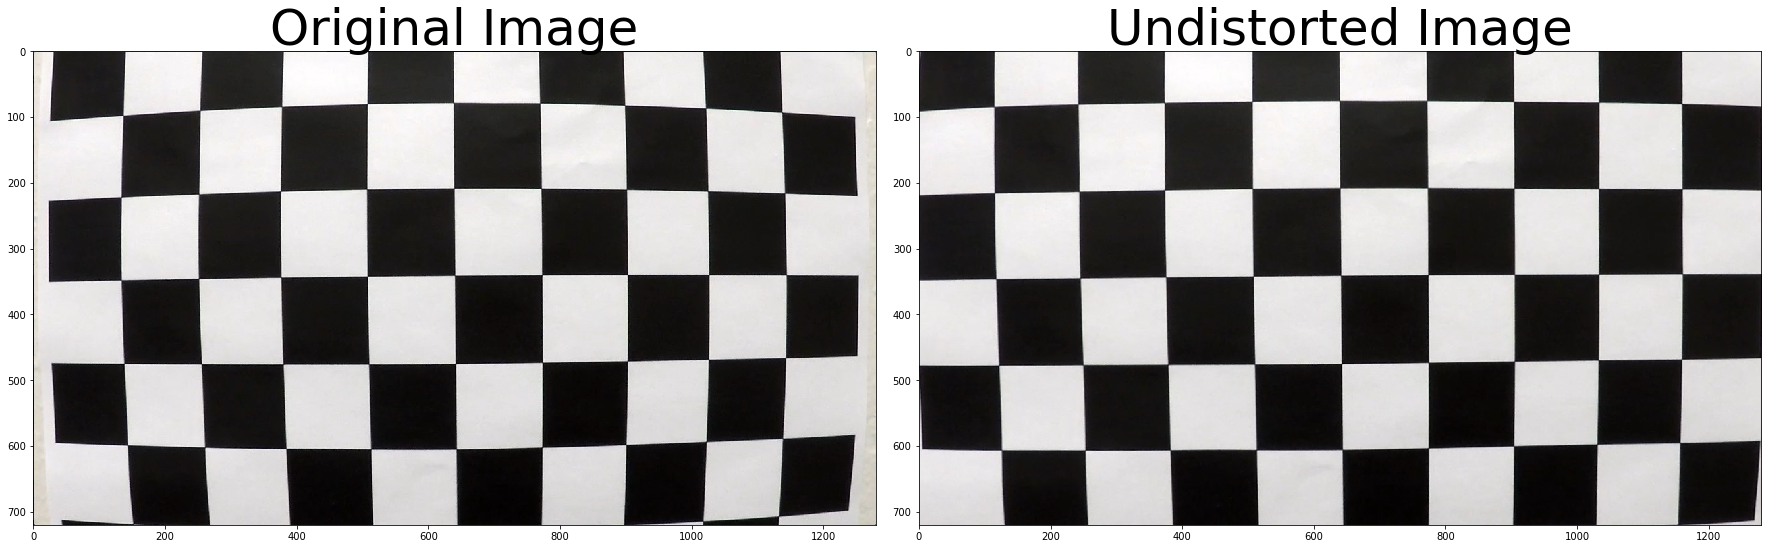

In [40]:
####################################
### Step 1: Calibrate the camera ###
####################################
List_Files = glob.glob('camera_cal/calibration*')
nx = 9
ny = 6

# Mtx, Dist = Calibration_Matrix (List_Files, nx, ny)
for Files in List_Files:
    base=os.path.splitext(os.path.basename(Files))[0]
#     print(Files)
    Img = mpimg.imread(Files)
    Undistorted_Img = cv2.undistort(Img, Mtx, Dist, None, Mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(Img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(Undistorted_Img)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('camera_cal/' + base + '_output.jpg')


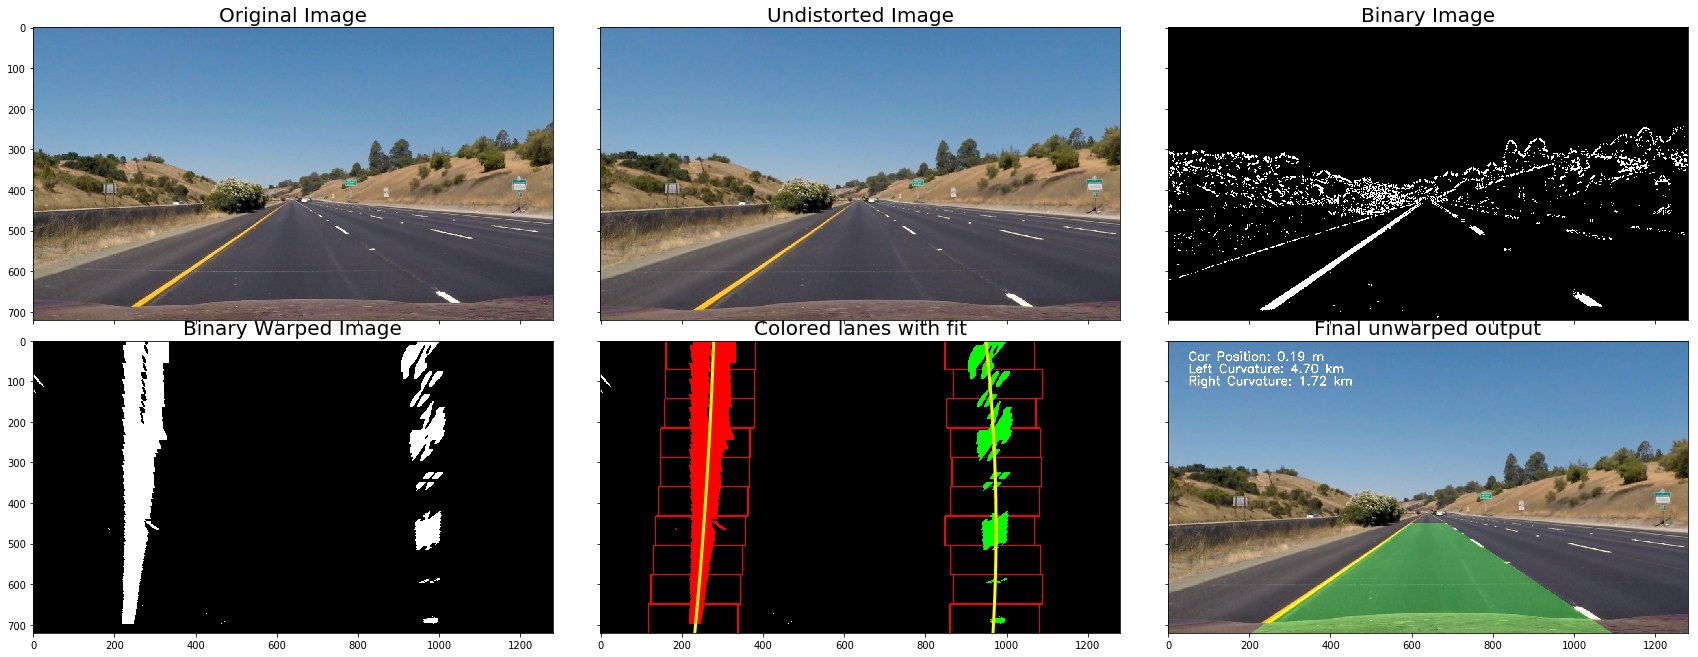

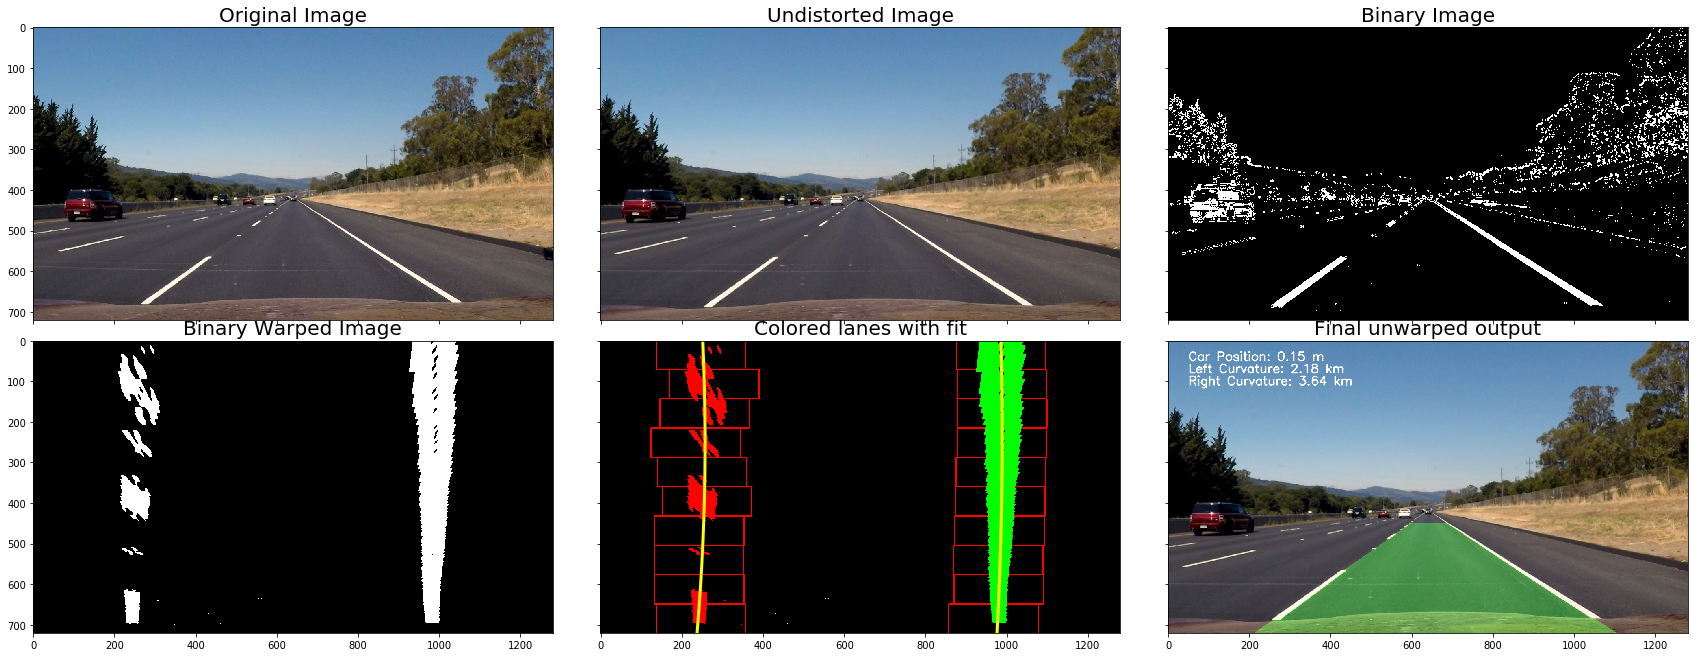

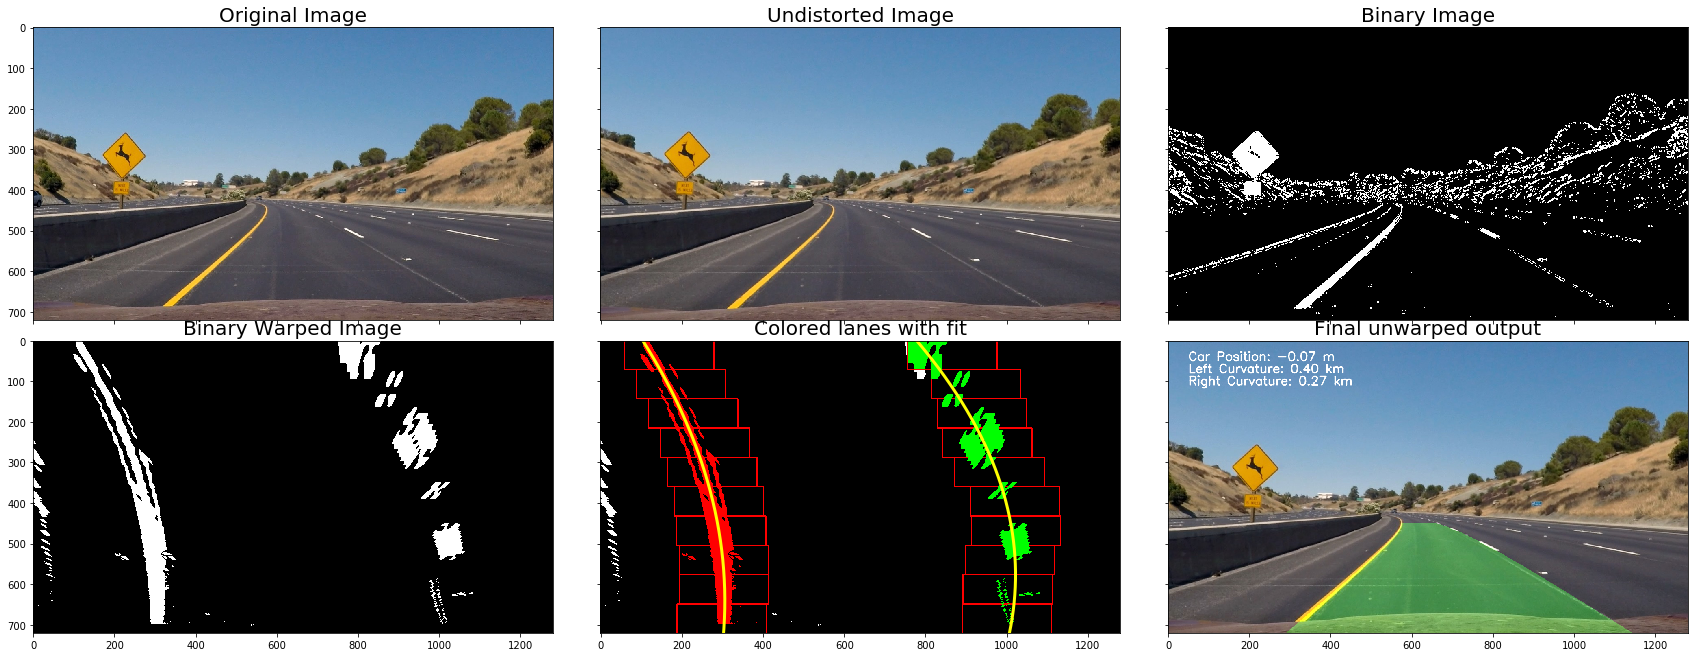

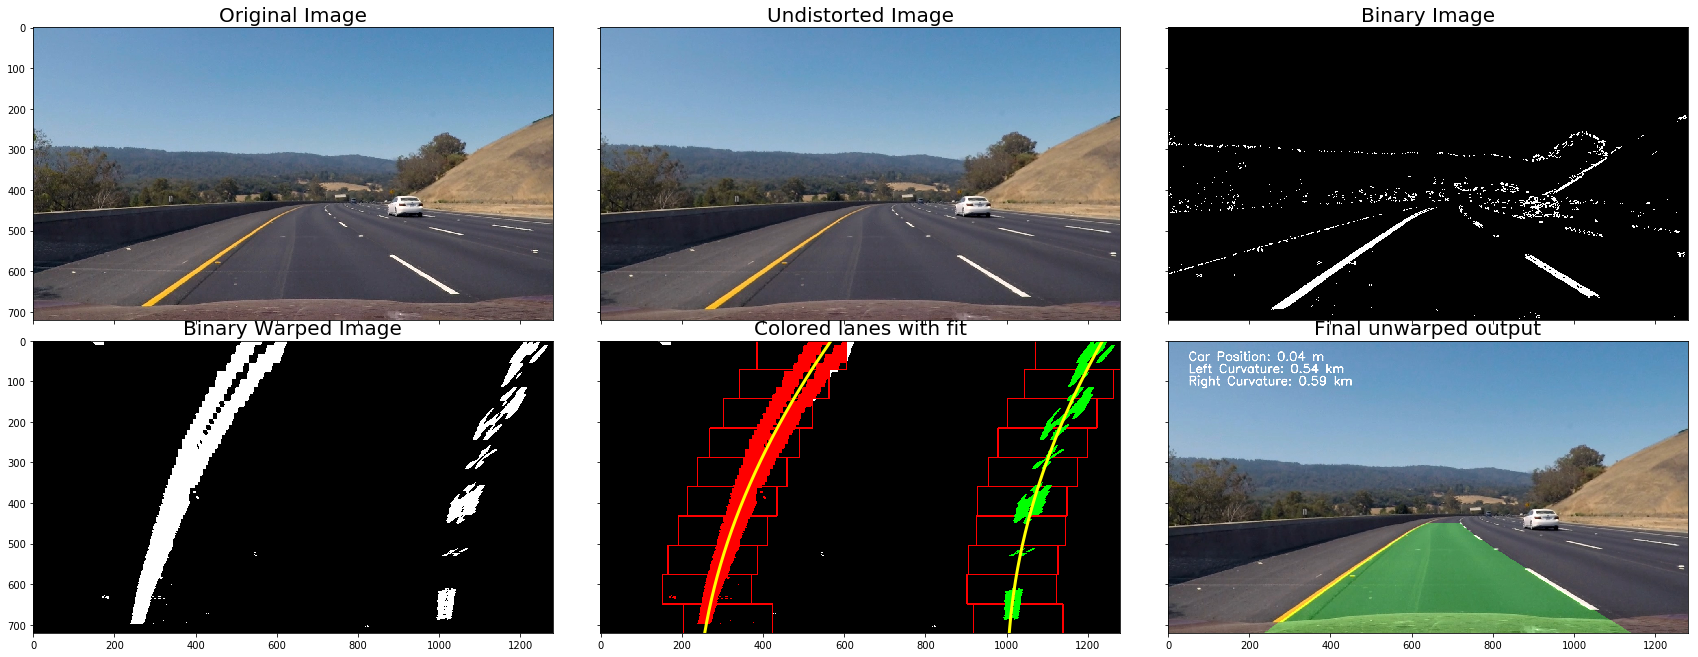

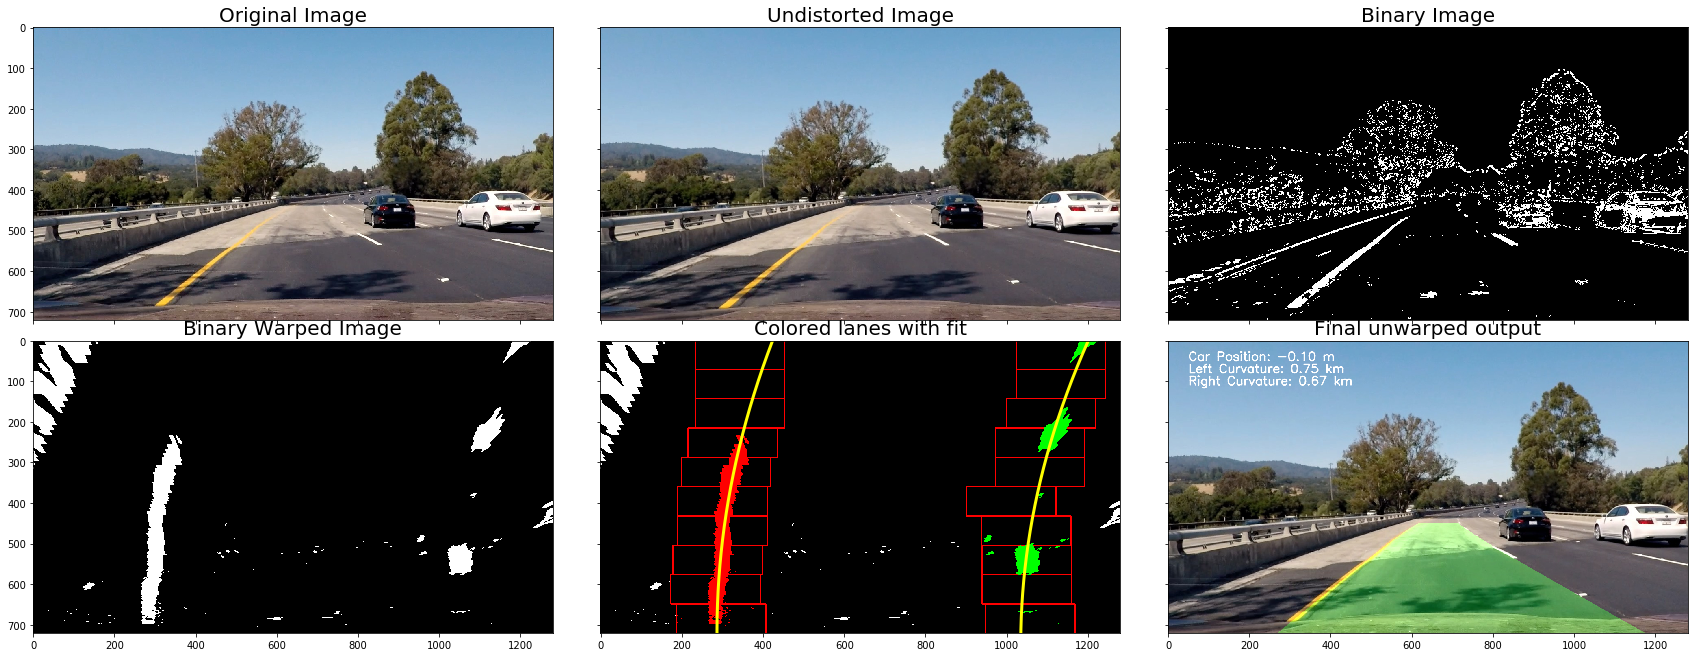

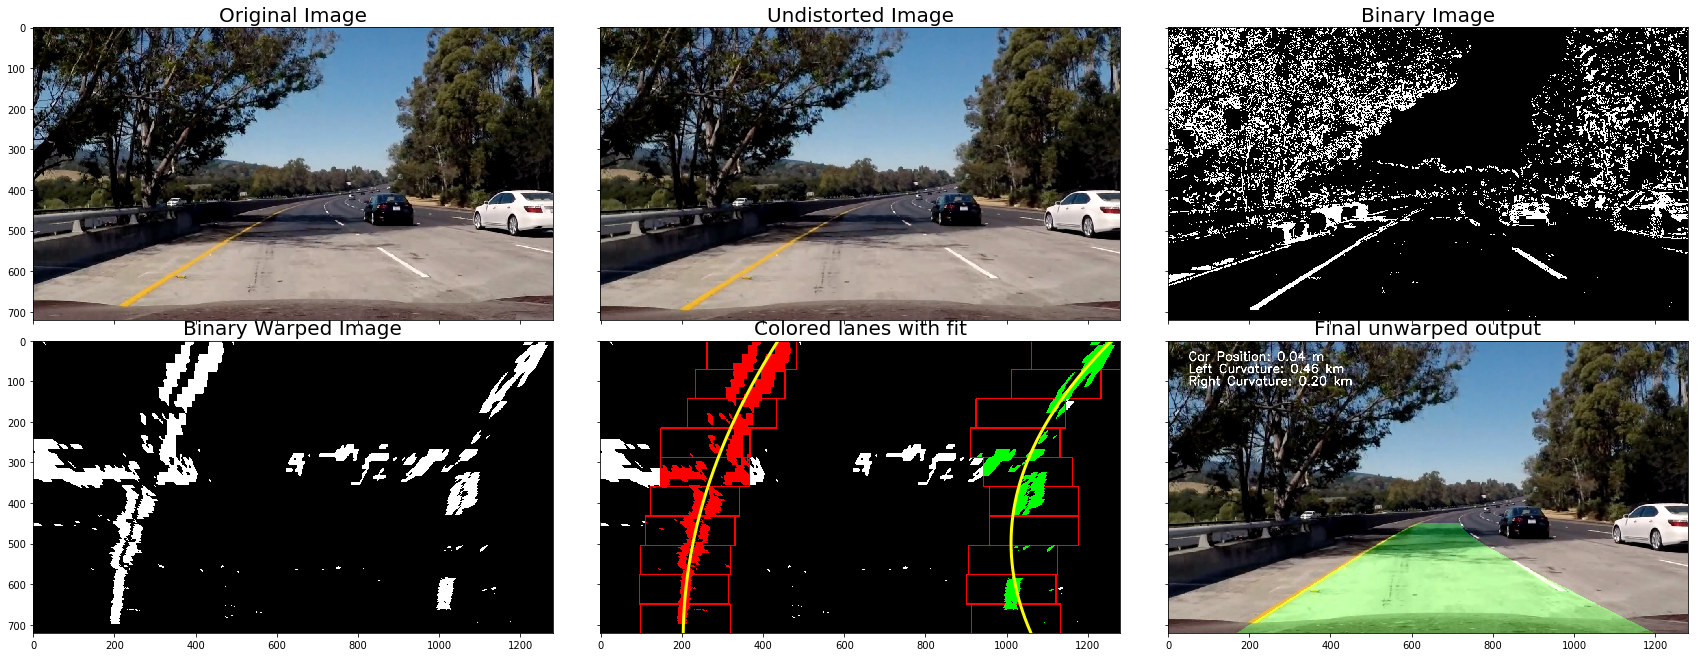

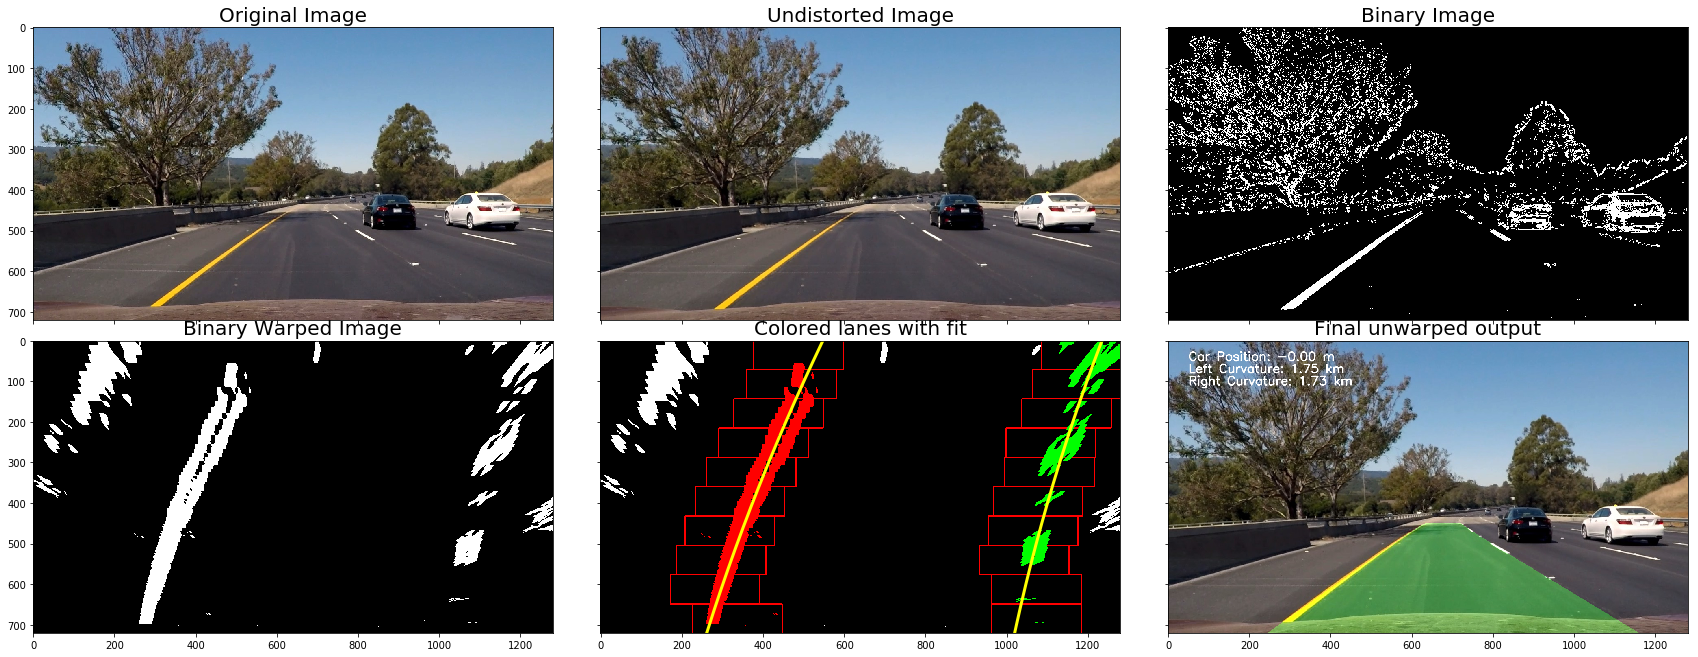

In [31]:
#####################################
### Step 2 : Undistort each image ###
#####################################
List_Img= os.listdir('test_images')
for Image_Name in List_Img:
# for Image_Name in [List_Img[4]]:
    # Img = mpimg.imread('test_images/test1.jpg')
    Img = mpimg.imread('test_images/' + Image_Name)
    Undistorted_Img = cv2.undistort(Img, Mtx, Dist, None, Mtx)
    
#############################################################################
### Step 3: Apply color and grandient thresholds to obtain a binary image ###
#############################################################################
    S_Color_binary = S_Color_Threshold(Undistorted_Img, S_Color_thresh = (150,255))
    Absolute_Sobel_x = Absolute_Sobel_Threshold(Undistorted_Img, orient='x', sobel_kernel=9, Abs_thresh=(20, 120))
    Absolute_Sobel_y = Absolute_Sobel_Threshold(Undistorted_Img, orient='y', sobel_kernel=9, Abs_thresh=(20, 120))
    Magnitude_Sobel = Magnitude_Threshold(Undistorted_Img, sobel_kernel=9, mag_thresh=(50, 255))
    Direction_Sobel = Direction_Threshold(Undistorted_Img, sobel_kernel=15, dir_thresh=(0.7,1.3))
    Binary_Img = np.zeros_like(S_Color_binary)
    Binary_Img [((Absolute_Sobel_x == 1) & (Absolute_Sobel_y == 1)) | ((Magnitude_Sobel == 1) & (Direction_Sobel == 1)) |
                (S_Color_binary == 1)] = 1
    
#########################################################
### Step 4: Perspective transform of the binary image ###
#########################################################
    #Defining a rectangle on the image
    src = np.float32([[230, 700], [1100, 700], [690, 450], [590, 450]])

    #Defining destination points of the rectangle in the warped image
    dst = np.float32([[230,700], [1000, 700], [1000,0], [230,0]])

    #Calculating direct and inverse matrix of the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    Binary_Warped_Img = cv2.warpPerspective(Binary_Img, M, (Binary_Img.shape[1], Binary_Img.shape[0]), flags=cv2.INTER_LINEAR)
    
##########################################################
### Step 5: Find each lane pixels and fit through them ### 
##########################################################
    Lane_Fit_Img, Left_Lane_Fit, Right_Lane_Fit = Fit_Lanes(Binary_Warped_Img)
    Plot_y= np.linspace(0, Binary_Warped_Img.shape[0]-1, Binary_Warped_Img.shape[0])
    try:
        Left_Lane_Fit_x = Left_Lane_Fit[0]*Plot_y**2 + Left_Lane_Fit[1]*Plot_y + Left_Lane_Fit[2]
        Right_Lane_Fit_x = Right_Lane_Fit[0]*Plot_y**2 + Right_Lane_Fit[1]*Plot_y + Right_Lane_Fit[2]
    except TypeError:
        # Avoidserror if fit was still impossible
        print('Fit not possible')
        Left_Lane_Fit_x = 1*Plot_y*2 + 1*Plot_y
        Right_Lane_Fit_x = 1*Plot_y*2 + 1*Plot_y
    
#################################################################
### Step 6: Draw the found lane back to the undistorted image ### 
#################################################################
    Final_Img = Draw_Lane (Undistorted_Img, Binary_Warped_Img, Left_Lane_Fit, Right_Lane_Fit)
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9), sharex ='all', sharey = 'all')
    f.tight_layout()
    ax1.imshow(Img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(Undistorted_Img)
    ax2.set_title('Undistorted Image', fontsize=20)
    ax3.imshow(Binary_Img, cmap ='gray')
    ax3.set_title('Binary Image', fontsize=20)
    ax4.imshow(Binary_Warped_Img, cmap ='gray')
    ax4.set_title('Binary Warped Image', fontsize=20)
    ax5.imshow(Lane_Fit_Img)
    ax5.set_title('Colored lanes with fit', fontsize=20)
    ax5.plot(Left_Lane_Fit_x, Plot_y, color = 'yellow', linewidth = 3)
    ax5.plot(Right_Lane_Fit_x, Plot_y, color = 'yellow', linewidth = 3)
    ax6.imshow(Final_Img)
    ax6.set_title('Final unwarped output', fontsize=20)
    